# Data Analysis

# Clinic 3: Classification with missing values & inbalanced data

## DELIVERABLES (DEADLINE 22/March late night, wildcards possible)

Instructions for the deliverable: 

* Make sure that you include a proper amount/mix of comments, results and code.

* In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook.

* You are asked to deliver **only your executed notebook file, .ipnyb** and nothing else. Enjoy!

* The second part of the assignment is purposefully left open-ended.  You will be allowed to build a linear model of your choice to better predict the price. 

* Honor code applies to these tasks. Only individual work should be submitted.

* Data science is a collaborative activity. While you may talk with others about the clinic, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** below.

**Names of collaborators**: 
***


# 0. Introduction

In this clinic, we will continue navigating the amazing world of modeling and explore classification models under extreme inbalance and missing values scenarios.

The first part of the assignment (Questions 1-9) will help you understand the impact of inbalance and missingness in the classification performance and explore different scenarios on how to improve. Most steps are laid out for you, but you are welcome to deviate.

The second part of the assignment (Question 10) is purposefully left open-ended (as in previous clinics). In this case, you will be allowed to compare different classifiers of your choice in an effort to deal with the imbalance in the data. 

After this clinic, you should feel comfortable with the following:

1. Run Classification Models (Logistic Regression, Decision Trees, Random Forests, etc.) in Python
1. Explain and tackle issues like missing values or class inbalance in your dataset
1. Judge the results of a classification model using AUROC scores
1. Select a proper algorithm that works well with your data using techniques (see also last week) like:
    * Cross Validation
    * Regularization


## Score breakdown

Question | Points
--- | ---
[Question 1](#q1) | 3
[Question 2](#q2) | 3
[Question 3](#q3) | 4
[Question 4](#q4) | 4
[Question 5](#q5) | 4
[Question 6](#q6) | 6
[Question 7](#q7) | 4
[Question 8](#q8) | 8
[Question 9](#q9) | 4
[Question 10](#q10)| 15 
Total | 55

This score will be scaled down to 1 and that will be your final clinic score.

In [280]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import seaborn as sns
sns.set(context='paper')

## Part 1: Determine the Inbalance (Asymmetry)

First, we would like to notice in our data that they are highly unbalanced (assymetric). Load the data which should contain 9 columns (`health`, `age`, `sex`, `educ`, `sexornt`, `partyid`, `race`, `married`, `income`). `Age`, `educ` (how many years of education a person has) and `income` are quantitative, the others are qualitative.

In [392]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


Our goal is to predict if a person is in poor health or not. Let's create some dummy variables in order to measure that.


In [393]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth

In [352]:
gssdata.describe()

,age,educ,married,income,poorhealth,notpoorhealth
count,1551.000000,1551.000000,1551.000000,963.000000,1551.000000,1551.000000
mean,48.172792,13.803353,0.732431,15633.177570,0.063830,0.936170
std,17.051151,3.011700,0.442835,5064.191118,0.244528,0.244528
min,18.000000,0.000000,0.000000,500.000000,0.000000,0.000000
25%,33.500000,12.000000,0.000000,13750.000000,0.000000,1.000000
50%,48.000000,14.000000,1.000000,18750.000000,0.000000,1.000000
75%,61.000000,16.000000,1.000000,18750.000000,0.000000,1.000000
max,89.000000,20.000000,1.000000,18750.000000,1.000000,1.000000


In [353]:
gssdata['poorhealth'].value_counts()

poorhealth
0    1452
1      99
Name: count, dtype: int64

### Question 1 <a name="q1"></a>

a) Can you quantify what is the degree of inbalance? Mention a percentage of the split between the positive and the negative class.<br>
b) What is the majority and the minority class?<br>
c) What would be the accuracy of a classifier that predicts everybody NOT being in poor health?<br>
d) Discuss (with each other and the teachers) why accuracy is not a good metric.<br>

**ANSWER**
a - the positive class is poorhealth, the negative class is notpoorhealth
b - the majority class is notpoorhealth, the minority class is poorhealth
c - 1452 / (1452 + 99) = 93.6%
d - accuracy is not a good metric because it does not take into account the dimension of the dataset. For example, if we had 100 positive entries, and 5 negative ones, and selected all 100 as being positive, we would have an accuracy of 95%, but we did not correctly identify a single negative

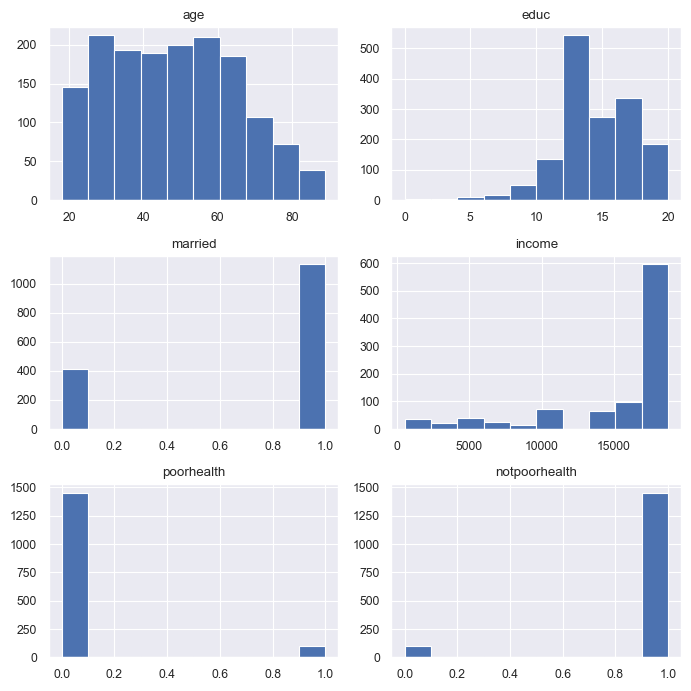

In [58]:
####HERE YOU CAN ADD CODE AND MORE COMMENTS

gssdata.hist(figsize=(7,7))
plt.tight_layout()

## Part 2: Fit a logistic model ignoring missing values

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model. In part 3, you will be asked to regularize (with cross-validation) to make sure you do not overfit, but for this part, we will keep things simple.

First, we need to do a small amount of data clean-up (ignoring missingness for now in `income`). Best practice would be to split into train/test first before looking at the data, but again, we can keep it simple in this part.

If you ignore the missingness `sklearn` might crash (`ValueError: Input contains NaN, infinity or a value too large for dtype('float64')`.) So you can also consider not using that variable in the model

In [354]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
dummy_vars2 = pd.get_dummies(gssdata[['health']])
gssdata = gssdata.join(dummy_vars)
gssdata = gssdata.join(dummy_vars2)

In [355]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.head()

(1551, 26)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white,health_excellent,health_fair,health_good,health_poor
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,True,True,False,False,False
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,True,True,False,False,False
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,False,False,True,False,False,True,False,False,True,False
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,False,True,False,False,False,True,True,False,False,False
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,False,True,False,False,False,True,False,False,False,True


In [75]:
gssdata.columns

Index(['health', 'age', 'sex', 'educ', 'sexornt', 'partyid', 'race', 'married',
       'income', 'poorhealth', 'notpoorhealth', 'female', 'sexornt_bisexual',
       'sexornt_dont know', 'sexornt_heterosexual or straight',
       'sexornt_homosexual or gay', 'partyid_dem', 'partyid_other',
       'partyid_rep', 'race_black', 'race_other', 'race_white',
       'health_excellent', 'health_fair', 'health_good', 'health_poor'],
      dtype='object')

In [76]:
gssdata['health'].value_counts()

health
good         737
excellent    414
fair         301
poor          99
Name: count, dtype: int64

In [77]:
gssdata['educ'].value_counts()

educ
12    420
16    286
14    194
13    122
18     87
11     80
15     78
20     65
10     54
17     50
19     32
8      27
9      22
6      14
5       8
3       4
7       3
0       3
2       1
4       1
Name: count, dtype: int64

In [78]:
bins = [0, 8, 12, 16, 20]  # bins for years of education
labels = ['Less than High School', 'High School', 'Some College', 'College and Beyond']
gssdata['educ_group'] = pd.cut(gssdata['educ'], bins=bins, labels=labels, right=False) # 'merge' the gssdata with the new categories


In [79]:
dummy_vars3 = pd.get_dummies(data = gssdata[['educ_group']])
gssdata = gssdata.join(dummy_vars3)

In [81]:
gssdata

,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,race_white,health_excellent,health_fair,health_good,health_poor,educ_group,educ_group_Less than High School,educ_group_High School,educ_group_Some College,educ_group_College and Beyond
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,True,True,False,False,False,College and Beyond,False,False,False,True
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,True,True,False,False,False,College and Beyond,False,False,False,True
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,True,False,False,True,False,Some College,False,False,True,False
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,True,True,False,False,False,College and Beyond,False,False,False,True
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,True,False,False,False,True,High School,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,good,89,female,14,heterosexual or straight,rep,white,1,NaN,0,...,True,False,False,True,False,Some College,False,False,True,False
1547,good,56,male,12,heterosexual or straight,other,white,1,18750.0,0,...,True,False,False,True,False,Some College,False,False,True,False
1548,excellent,24,male,14,heterosexual or straight,dem,white,0,11250.0,0,...,True,True,False,False,False,Some College,False,False,True,False
1549,fair,27,male,13,heterosexual or straight,dem,white,0,18750.0,0,...,True,False,True,False,False,Some College,False,False,True,False


### Question 2 <a name="q2"></a>

In the code below try to fit your logistic regression model and provide some short comments on the performance of the model. You don't need to be detailed (yet), but make sure to make 1-2 observations at least.

In [161]:
#HERE YOUR CODE TO FIT THE MODEL
X = gssdata[['age', 'health_fair', 'health_good', 'health_excellent', 'educ_group_High School', 'educ_group_Some College', 'educ_group_College and Beyond', 'female', 'income', 'married']]
y = gssdata['poorhealth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # did the test/train split

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)
#Look up LogisticRegression() from scikitlearn

0.9835164835164835


**ANSWER**

I find that the accuracy of the model is very high, never below 95%, no matter what predictors I use it seems. 

I also know however that the majority class is much more present than the minority class (99 for minority vs 1452 for majority), so maybe this unusually high accuracy is a result of this.

---

## 2a: Handling missingness approach \#1: remove observations. 

We do not know how sklearn will treat the missing values (the `NaN`s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

### Question 3 <a name="q3"></a>

In the code below, remove all observations that are not complete. Report on how many samples were dropped. Do a quick check to see how dropping observations affected the amount of poor health individuals. Do an appropriate plot to show this.

***YOU MAY WANT TO RE RUN THE CELL BELOW, I ALREADY DROPPED AND ALTERED THE DF IN THE QUESTION 1***

In [187]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth

#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

NUMBER OF ROWS BEFORE DROPPING NAN -> 1551
NUMBER OF ROWS AFTER  DROPPING NAN -> 1551
NUMBER OF ENTRIES DROPPED -> 588


Text(0.5, 1.0, "Distribution of 'poorhealth' (After)")

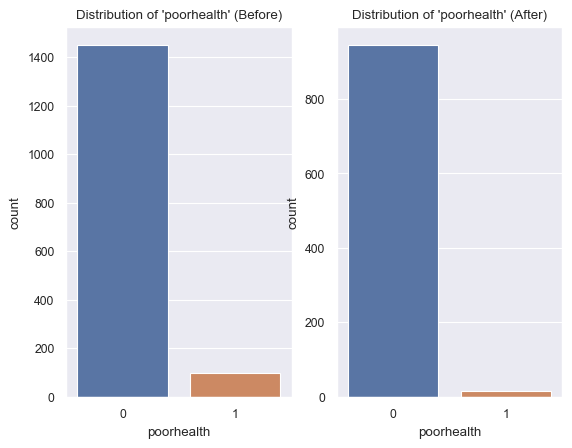

In [188]:
##In the code below: Remove all observations that are not complete
##Report on how many samples were dropped.
print(f"NUMBER OF ROWS BEFORE DROPPING NAN -> {gssdata.shape[0]}")
gssdata_full = gssdata.dropna()
print(f"NUMBER OF ROWS AFTER  DROPPING NAN -> {gssdata.shape[0]}")
print(f"NUMBER OF ENTRIES DROPPED -> 588")

#Do a quick check to see how dropping observations affected the amount of poor health individuals
#Do an appropriate plot to show this (e.g. boxplot)

plt.subplot(1, 2, 1) # this plot is for BEFORE
sns.countplot(x='poorhealth', data=gssdata)
plt.title("Distribution of 'poorhealth' (Before)")

plt.subplot(1, 2, 2) # this plot is for AFTER 
sns.countplot(x='poorhealth', data=gssdata_full)
plt.title("Distribution of 'poorhealth' (After)")

In [189]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata_full.shape[0]), test_size=0.25)

#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['poorhealth'].iloc[itrain]
y_test = gssdata_full['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((722,), (722, 6), (241,), (241, 6))

In [197]:
#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
# Then move below to be reminded on the confusion matrix
#####################

logit = LogisticRegression(C=1000000) #<-- this should be the name of your model so as to work below with the confusion matrix 

logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.979253112033195


**ANSWER**

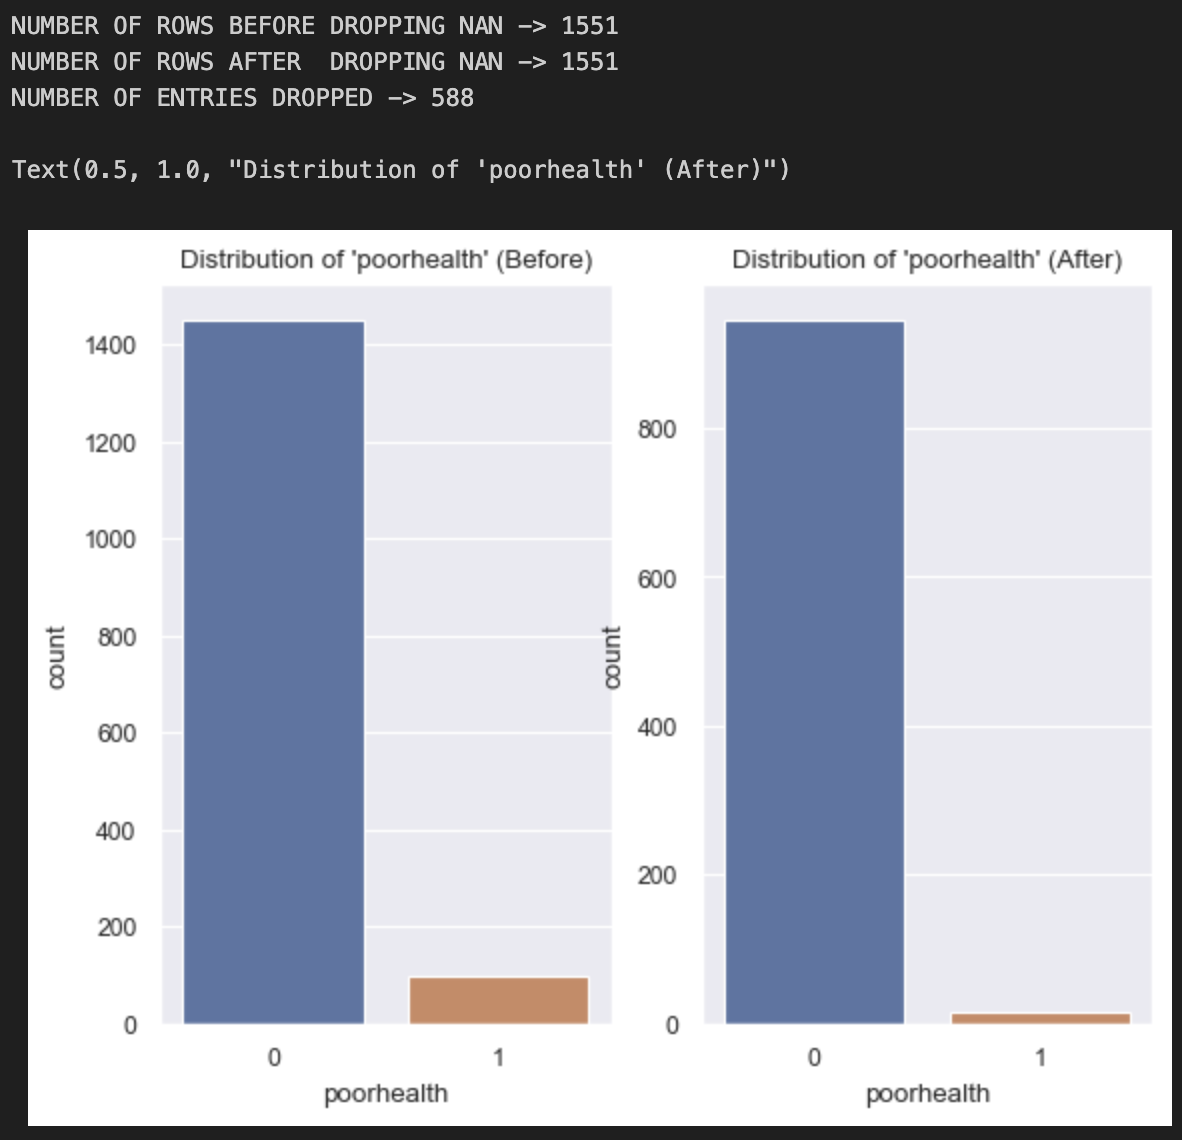

### Question 4 <a name="q4"></a>

Fit a logistic regression mode with `C=1000000` (that means that we don't any regularization) and evaluate the classification accuracy on the test set. Discuss whether this accuracy is good/bad.

Then move below to be reminded on the confusion matrix.

In [198]:
from sklearn.metrics import accuracy_score

#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
# Then move below to be reminded on the confusion matrix
#####################

logit = LogisticRegression(C=1000000) #<-- this should be the name of your model so as to work below with the confusion matrix 

logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.979253112033195


**ANSWER**

I have fitted the logistic regression model with C = 100000 to the data, and have found that the accuracy of the model on the test set is ~97.9%.

Such a high accuracy means we are correctly predicting in 97.9% of the cases, we are predicting correctly that the person has good health, however, there are so many good health people compare to bad health people in the data that even if we were to set the filter of classification to just be "good health" for all entries, the accuracy of the model would not be too far away from this one.

## Reminder: The Confusion Matrix & Some Useful Functions

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In `sklearn`, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



In [199]:
#the name of your model should be logit1 (to work with the code below)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,logit.predict(X_test)))

[[236   0]
 [  5   0]]


The following function can be used to create confusion tables with different thresholds (same as we did in the notebook explaing AUROC)

In [200]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [202]:
#Try it here!

print(confusion_matrix(y_test,t_repredict(logit, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit, 0.06, X_train)))

[[231   5]
 [  4   1]]
[[680  31]
 [  9   2]]


The following fuction should create ROC curves for your models, based on the model and the ground truth. Feel free to change it and improve it!

In [203]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

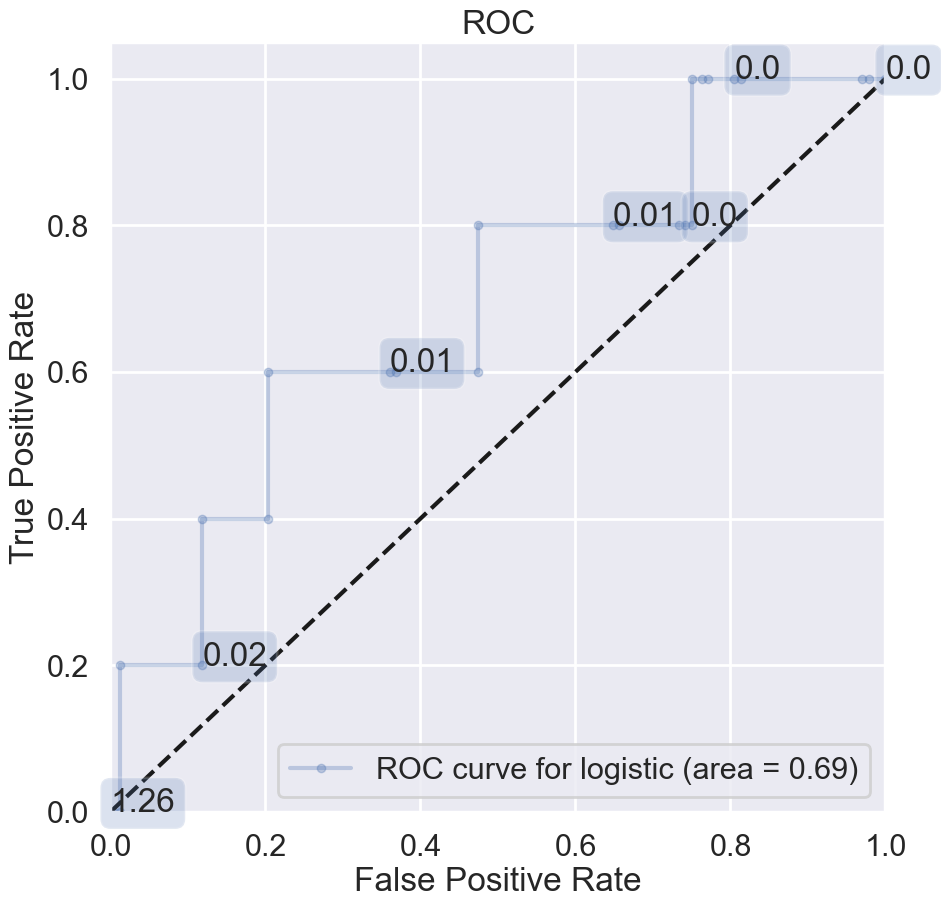

In [209]:
#This is how the above function should be used

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 5 <a name="q5"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**ANSWER**

The area under the ROC curve is 0.69, which is more than 0.5. This indicates that our model performs better to some extend than a model which just classifies data randomly (that would then be the dotted line in the middle).

We can see on this curve that the model has a high True Positive rate, and a lower False Positive rate, because the ROC curve is closer to the upper-left corner of the graph.

Overall, the model is decent, but not amazing yet.

## Let's get back the data with missingness

It's time to build a model to impute the missing data!

Text(0, 0.5, 'count')

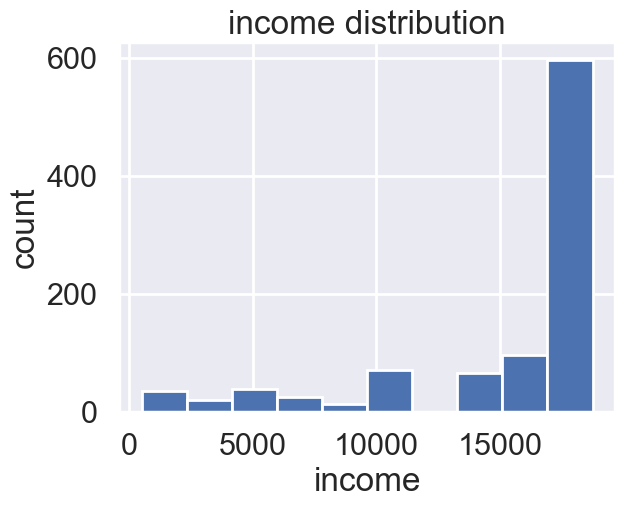

In [210]:
#first build a model to impute using data without missing 
hist = plt.hist(gssdata_full['income'])
plt.title("income distribution")
plt.xlabel("income")
plt.ylabel("count")

---

## 2b: Handling missingness approach \#2: impute the mean 

### Question 6 <a name="q6"></a>

In your first approach, make a copy of the original data frame and impute the missing values by assuming that every missing value shoudl be replaced by the mean. Make sure to do a histogram as well and compare it with the original!

Then fit a model (as before in 2a.) and judge the model accuracy. Use the functions for the ROC curve to establish the result.

[18750.         15633.17757009 16250.          9000.
  2000.         13750.         11250.          6500.
   500.          3500.          4500.          7500.
  5500.        ]


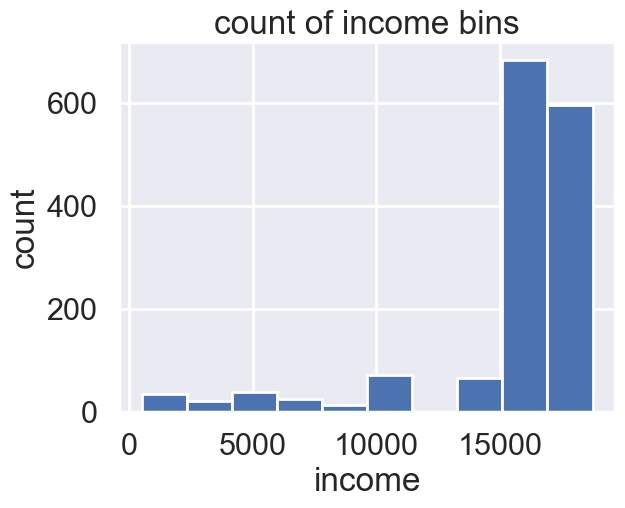

In [253]:
#back to the original data set with missingness, make a copy, and then impute the mean, plot it!
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth

#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] == 'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

gssdata['income'] = gssdata['income'].fillna(gssdata['income'].mean())

assert gssdata['income'].isna().sum() == 0 # will run if the NaNs were removed correctly

print(gssdata['income'].unique())

hist = plt.hist(gssdata['income'])
plt.title("count of income bins")
plt.xlabel("income")
plt.ylabel("count")

gssdata_no_nan = gssdata

***We do see that taking the mean of the income column and replacing all NaNs by it gives us a dataset which is even more skewed then before.***

This is because the mean was already very high in the original dataset, and replacing over 30% of the income entries by a high mean gives this result. 

In [248]:
###here, do a proper train/test split and a model training

X = gssdata[['age', 'female', 'income', 'married']]
y = gssdata['poorhealth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # did the test/train split

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9453376205787781


***We can see that the accuracy of the model is quite high once again, at over 90%***

In [251]:
#####################
#your code here: create confusion tables for some thresholds to have an idea of how data looks like
#####################

i = 0.05
while i < 1:
    print(f"y_test confusion matrix - threshold {i}")
    print(confusion_matrix(y_test, t_repredict(model, i, X_test)))
    print("\n")
    print(f"y_train confusion matrix - threshold {i}")
    print(confusion_matrix(y_train, t_repredict(model, i, X_train)))
    print("\n")
    i += 0.05

y_test confusion matrix - threshold 0.05
[[116 178]
 [  0  17]]


y_train confusion matrix - threshold 0.05
[[476 682]
 [  4  78]]


y_test confusion matrix - threshold 0.1
[[244  50]
 [ 16   1]]


y_train confusion matrix - threshold 0.1
[[1009  149]
 [  77    5]]


y_test confusion matrix - threshold 0.15000000000000002
[[262  32]
 [ 16   1]]


y_train confusion matrix - threshold 0.15000000000000002
[[1062   96]
 [  77    5]]


y_test confusion matrix - threshold 0.2
[[268  26]
 [ 16   1]]


y_train confusion matrix - threshold 0.2
[[1070   88]
 [  77    5]]


y_test confusion matrix - threshold 0.25
[[271  23]
 [ 17   0]]


y_train confusion matrix - threshold 0.25
[[1076   82]
 [  77    5]]


y_test confusion matrix - threshold 0.3
[[282  12]
 [ 17   0]]


y_train confusion matrix - threshold 0.3
[[1103   55]
 [  77    5]]


y_test confusion matrix - threshold 0.35
[[282  12]
 [ 17   0]]


y_train confusion matrix - threshold 0.35
[[1118   40]
 [  78    4]]


y_test confusion matr

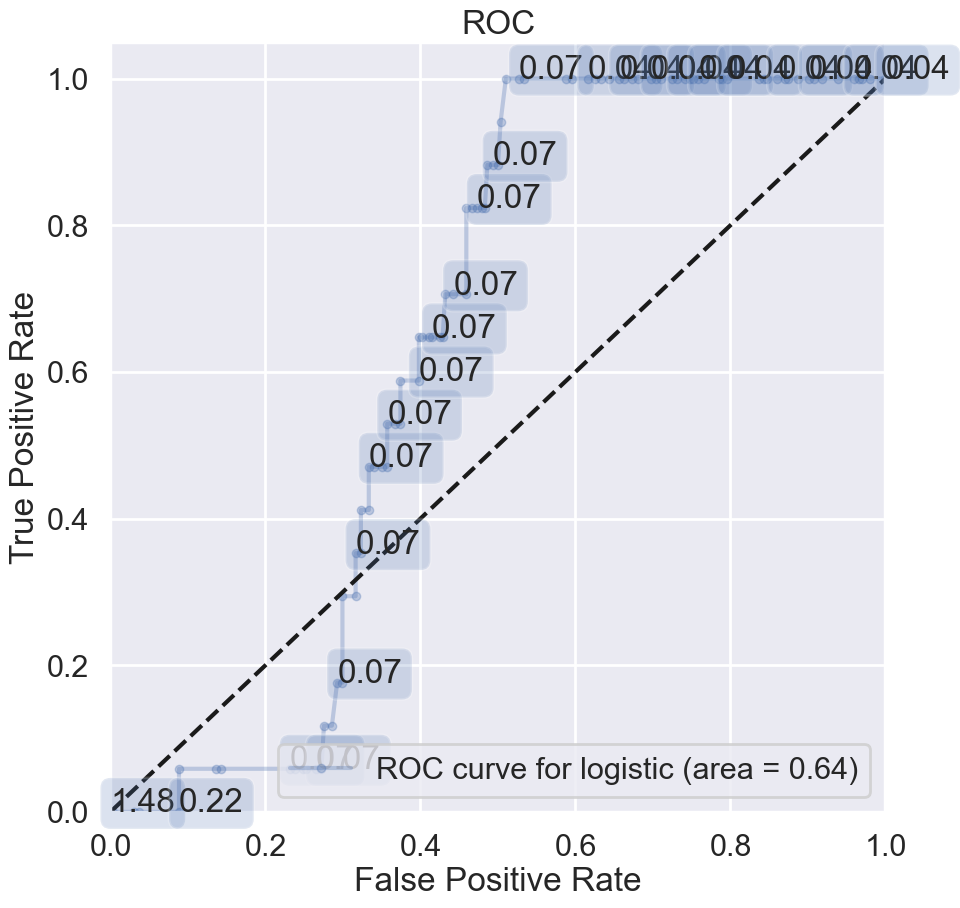

In [252]:
#####################
# your code here: create an ROC curve
#####################

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic", model, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 7 <a name="q7"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**ANSWER**

The ROC curve for the model trained on the imputed mean dataset goes under the middle-line in the bottom left corner. The model is predicting more false positives than if the model was guessing randomly. It then improves, which is interesting. 

The area under the ROC curve is also slightly lower than before, it now stands at 0.64..

---

## 2c: Handling missingness approach \#3: impute with a model (linear regression here)

The third and most sophisticated approach would be to fit a linear model (multiple regression) to estimate income based on the other features (`age`, `educ`, `sex`, `partyid`).

### Question 8 <a name="q8"></a>

Train this model below and then use it in order to compute the missing values. The steps should be as follows:

+ figure out which observations have missing values for income,
+ create the values you will use for imputation by:<br>
a) calculating the predicted values for the observations with missingness using the linear model<br>
b) use these values to impute back into the income variable in the missing entries<br>
+ Do a histogram to see how does that look like

In [362]:
#use the dataset without NAs here
#train a model

y = gssdata_no_nan['income']
X = gssdata_no_nan[['age', 'educ', 'female', 'partyid_dem', 'partyid_rep']]

income_model = LinearRegression()
income_model.fit(X, y)

y_pred = income_model.predict(X)

Then fill the missing data with the results you got. You can do that multiple ways, one way to use Python would be the following:

In [363]:
gssdata_imp = gssdata.copy()

In [364]:
gssdata_imp['income'] = np.where(pd.isna(gssdata_imp['income']), y_pred, gssdata_imp['income'])

In [365]:
gssdata_imp['income']

0       18750.000000
1       18750.000000
2       16631.968148
3       16524.992300
4       13747.782697
            ...     
1546    16677.352201
1547    18750.000000
1548    11250.000000
1549    18750.000000
1550    16250.000000
Name: income, Length: 1551, dtype: float64

count     1551.000000
mean     15628.247587
std       4055.003077
min        500.000000
25%      14614.194523
50%      16250.000000
75%      18750.000000
max      18795.263425
Name: income, dtype: float64

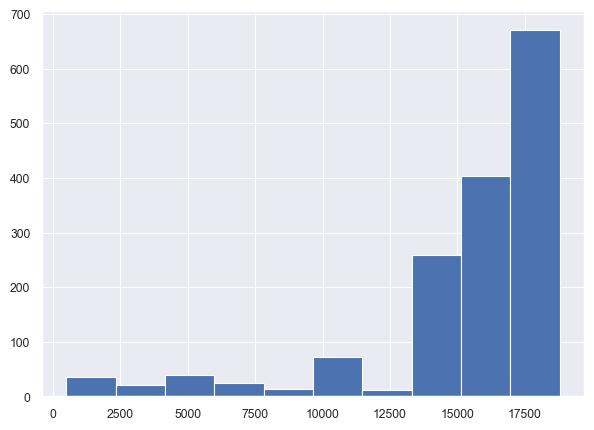

In [366]:
gssdata_imp['income'].hist(figsize=(7,5))
gssdata_imp['income'].describe()

In [386]:
#HERE FIT YOUR MODEL AS USUAL FOR PREDICTING THE HEALTH STATUS (POOR OR NOT)
###here, do a proper train/test split and a model training

#HERE YOUR CODE TO FIT THE MODEL
X = gssdata[['age', 'educ', 'female', 'partyid_dem', 'partyid_rep']]
y = gssdata['poorhealth']

#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # did the test/train split

In [387]:
#here you fit a model
#should be called logit3
logit3 = LogisticRegression()
logit3.fit(X_train, y_train)

y_pred = logit3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.932475884244373


y_test confusion matrix - threshold 0.05
[[145 145]
 [  7  14]]


y_train confusion matrix - threshold 0.05
[[652 510]
 [ 17  61]]


y_test confusion matrix - threshold 0.1
[[243  47]
 [ 12   9]]


y_train confusion matrix - threshold 0.1
[[991 171]
 [ 43  35]]


y_test confusion matrix - threshold 0.15000000000000002
[[270  20]
 [ 15   6]]


y_train confusion matrix - threshold 0.15000000000000002
[[1103   59]
 [  63   15]]


y_test confusion matrix - threshold 0.2
[[284   6]
 [ 16   5]]


y_train confusion matrix - threshold 0.2
[[1136   26]
 [  71    7]]


y_test confusion matrix - threshold 0.25
[[286   4]
 [ 20   1]]


y_train confusion matrix - threshold 0.25
[[1146   16]
 [  72    6]]


y_test confusion matrix - threshold 0.3
[[288   2]
 [ 21   0]]


y_train confusion matrix - threshold 0.3
[[1152   10]
 [  75    3]]


y_test confusion matrix - threshold 0.35
[[289   1]
 [ 21   0]]


y_train confusion matrix - threshold 0.35
[[1155    7]
 [  75    3]]


y_test confusion matrix -

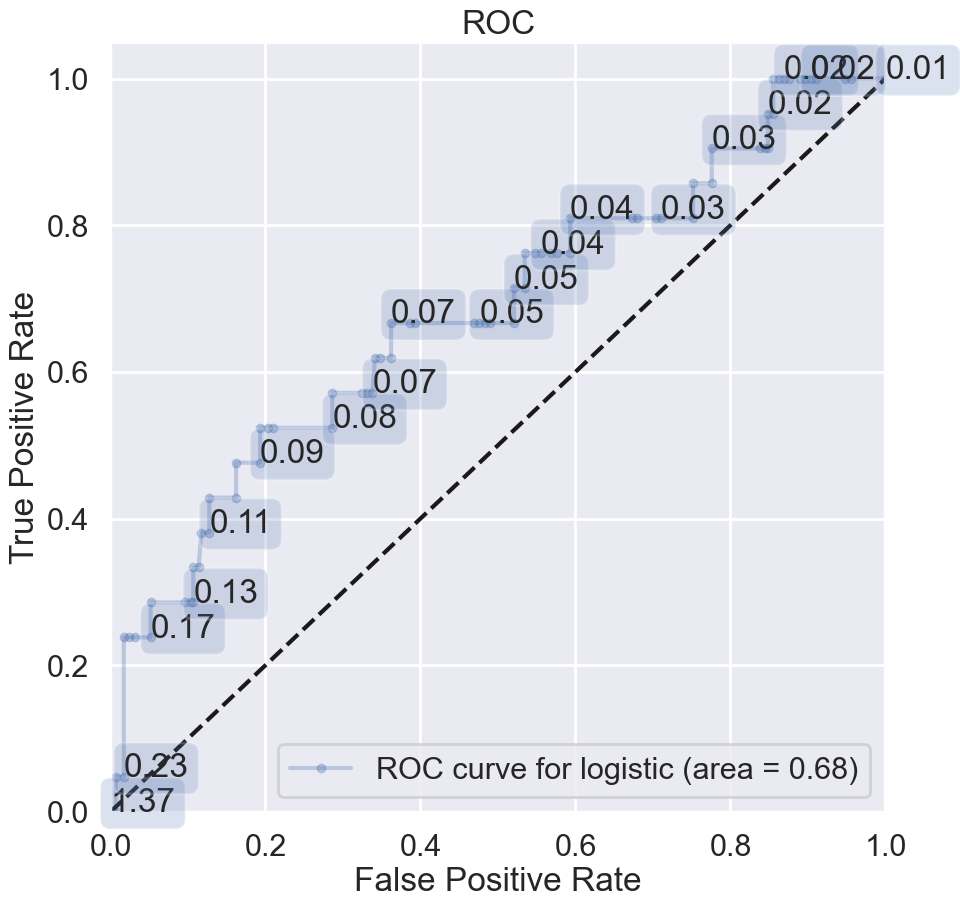

In [389]:
#MAKE CONFUSION TABLES FOR DIFFERENT THRESHOLDS AND DRAW THE AUROC CURVE

i = 0.05
while i < 1:
    print(f"y_test confusion matrix - threshold {i}")
    print(confusion_matrix(y_test, t_repredict(logit3, i, X_test)))
    print("\n")
    print(f"y_train confusion matrix - threshold {i}")
    print(confusion_matrix(y_train, t_repredict(logit3, i, X_train)))
    print("\n")
    i += 0.05

# create an ROC curve
    
sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax = make_roc("logistic", logit3, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 9 <a name="q9"></a>


Now comment on the performance of difference imputation methods and on the impact it has on the final model performance.


**ANSWER**

We can see that this model with the new imputed income does not perform better than the first model at all, it actually performs about the same. Maybe what is more notable here is that the curve seems more smooth than before. 

Compared to the model where we replaced all missing income entries by the mean of income, the model does perform better to some extent. This does depend on the train and test set, however.

The area under the curve is 0.68

## Part 3: Improving the model.

### Question 10 <a name="q10"></a>


Apply regularization (with cross-validation) to make sure not to overfit to the data and try also different models, like a Decision Tree or a Random Forest. Report on your results for which model handles inbalances in the best way.

**Your checklist**

Here is a checklist for this clinic (classification) made by a TA some years ago.

What are the correlations between variables?<br>
What is the distribution of your variables? How does the histogram look like? <br>
Are there missing values? How can you handle them? <br>
How does dropping missing values affect the distribution? <br>
How does imputing from mean affect the distribution? <br>
How does imputing from model affect the distribution? <br>
How does imputation influence correlation between variables? <br>
What is the difference between precision and accuracy? <br>
What is the difference between Type I and Type II error? <br>
How is a ROC curve build? What do the tresholds represent? <br>
How is the ROC curve affected by dropping NaN? <br>
How is the ROC curve affected by imputing mean? <br>
How is the ROC curve affected by imputing from a model? <br>
What is the difference between overfitting and class imbalance? <br> 
How does the the amount of folds in cross validation affect model performance? <br>

In [403]:
## your code goes here

gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth

In [404]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
dummy_vars2 = pd.get_dummies(gssdata[['health']])
gssdata = gssdata.join(dummy_vars)
gssdata = gssdata.join(dummy_vars2)

In [405]:
columns_to_drop = ['sex', 'sexornt', 'partyid', 'race', 'health']

In [406]:
gssdata.drop(columns_to_drop, axis = 1, inplace = True)

In [407]:
gssdata.corr()

,age,educ,married,income,poorhealth,notpoorhealth,female,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,...,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white,health_excellent,health_fair,health_good,health_poor
age,1.000000,0.009984,0.476572,0.225628,0.120831,-0.120831,-0.002342,-0.110797,-0.010211,0.104828,...,-0.011808,-0.112310,0.111197,-0.112809,-0.131150,0.184492,-0.055284,0.028022,-0.032368,0.120831
educ,0.009984,1.000000,0.087263,0.234909,-0.159907,0.159907,-0.021942,0.003694,-0.030457,-0.023318,...,0.064863,-0.163595,0.074070,-0.068367,-0.134148,0.149634,0.204012,-0.220283,0.072013,-0.159907
married,0.476572,0.087263,1.000000,0.208988,0.020789,-0.020789,0.031665,-0.092552,-0.026698,0.146765,...,-0.117344,-0.028393,0.150611,-0.172142,-0.063152,0.186748,0.028887,-0.027479,-0.014003,0.020789
income,0.225628,0.234909,0.208988,1.000000,-0.105339,0.105339,-0.190673,-0.096785,-0.023560,0.072041,...,-0.019767,-0.086460,0.094968,-0.105474,-0.040223,0.115782,0.034679,-0.112832,0.078383,-0.105339
poorhealth,0.120831,-0.159907,0.020789,-0.105339,1.000000,-1.000000,0.000676,-0.001944,-0.013278,-0.010287,...,0.002811,0.045162,-0.042640,0.002151,0.015498,-0.012510,-0.157563,-0.128133,-0.248460,1.000000
notpoorhealth,-0.120831,0.159907,-0.020789,0.105339,-1.000000,1.000000,-0.000676,0.001944,0.013278,0.010287,...,-0.002811,-0.045162,0.042640,-0.002151,-0.015498,0.012510,0.157563,0.128133,0.248460,-1.000000
female,-0.002342,-0.021942,0.031665,-0.190673,0.000676,-0.000676,1.000000,0.036266,-0.004509,0.025108,...,0.051485,0.034737,-0.085630,0.085529,-0.004539,-0.067935,0.016727,0.033409,-0.041605,0.000676
sexornt_bisexual,-0.110797,0.003694,-0.092552,-0.096785,-0.001944,0.001944,0.036266,1.000000,-0.007497,-0.699379,...,0.049335,0.010929,-0.062437,-0.015093,0.023440,-0.003676,0.022135,-0.049757,0.020749,-0.001944
sexornt_dont know,-0.010211,-0.030457,-0.026698,-0.023560,-0.013278,0.013278,-0.004509,-0.007497,1.000000,-0.241199,...,-0.047825,0.066903,-0.007477,0.012721,0.024548,-0.027557,-0.030683,0.039335,0.002528,-0.013278
sexornt_heterosexual or straight,0.104828,-0.023318,0.146765,0.072041,-0.010287,0.010287,0.025108,-0.699379,-0.241199,1.000000,...,-0.076942,-0.015627,0.096131,-0.004651,-0.002011,0.005256,-0.053312,0.030761,0.027899,-0.010287
